In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Logistic Regression
## Classification Using Linear Regression
Load your data.

In [3]:
from helpers import sample_data, load_data, standardize

# load data.
height, weight, gender = load_data()

# build sampled x and y.
seed = 1
y = np.expand_dims(gender, axis=1)
X = np.c_[height.reshape(-1), weight.reshape(-1)]
y, X = sample_data(y, X, seed, size_samples=200)
x, mean_x, std_x = standardize(X)

Use `least_squares` to compute w, and visualize the results.

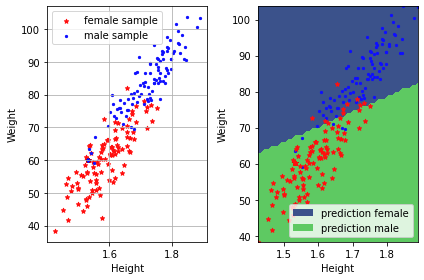

In [4]:
from least_squares import least_squares
from plots import visualization

def least_square_classification_demo(y, x):
    # ***************************************************
    # INSERT YOUR CODE HERE
    # classify the data by linear regression: TODO
    # ***************************************************
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w, loss = least_squares(y, tx)

    visualization(y, x, mean_x, std_x, w, "classification_by_least_square")
    
least_square_classification_demo(y, x)

## Logistic Regression

Compute negative log likelihood loss.

We define the sigmoid function:

$$\sigma(x) := \frac{e^{x}}{1+e^{x}} = \frac{1}{1+e^{-x}}$$

In [5]:
def sigmoid(t):
    """apply the sigmoid function on t."""
    return 1 / (1 + np.exp(-t))

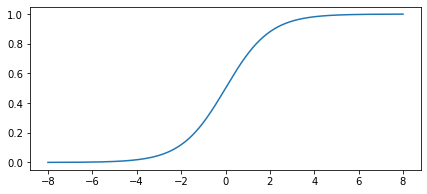

In [6]:
plt.figure(figsize=(7, 3))
t = np.linspace(-8, 8, 400)
plt.plot(t, sigmoid(t));

The negative log likelihood is

$$\begin{align}
\mathcal L (\mathbf w) &= \textstyle\sum_{n=1}^N \left[\log(1+e^{\mathbf{x_n}^\top \mathbf w}) - y_n \mathbf{x_n}^\top \mathbf w \right]
\end{align}$$

When trying to implement this efficiently with numpy, we can first compute the linear sum 

$$\mathbf s := X \mathbf w$$

and rewrite the terms in the sum as

$$a_n := \log(1+e^{s_n}) - (\mathbf y\circ \mathbf s)_n$$

with $\mathbf u \circ \mathbf v$ is the element-wise multiplication.

In [7]:
def calculate_loss(y, tx, w):
    """compute the loss: negative log likelihood."""
    s = tx.dot(w)
    loss_components = np.log(1 + np.exp(s)) - y * s
    return loss_components.sum()

The gradient of the negative log likelihood has a pretty nice compact notation:

$$\begin{align}
\vec \nabla_{\mathbf w} \mathcal L (\mathbf w) 
&= \textstyle \sum_{n=1}^N \mathbf x_n \left( \sigma\left(\mathbf x_n^\top \mathbf w\right) - \mathbf y \right)\\
&= X^\top \left[ \sigma\left(X\mathbf w\right) - \mathbf y \right]
\end{align}$$

In [8]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    return tx.T.dot(sigmoid(tx.dot(w)) - y)

### Using Gradient Descent
Implement your function to calculate the gradient for logistic regression.

In [9]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # compute the loss: TODO
    # ***************************************************
    loss = calculate_loss(y, tx, w)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # compute the gradient: TODO
    # ***************************************************
    grad = calculate_gradient(y, tx, w)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # update w: TODO
    # ***************************************************
    w = w - gamma * grad
    
    return loss, w

Demo!

Current iteration=0, loss=138.62943611198904
Current iteration=100, loss=43.46403230562902
Current iteration=200, loss=41.5458928087594
Current iteration=300, loss=41.098638973663114
Current iteration=400, loss=40.964870635605585
Current iteration=500, loss=40.920089458713036
Current iteration=600, loss=40.90418744318991
Current iteration=700, loss=40.89834994668996
Current iteration=800, loss=40.89616496609549
Current iteration=900, loss=40.89533753382109
Current iteration=1000, loss=40.895021964118996
Current iteration=1100, loss=40.89490108685556
Current iteration=1200, loss=40.89485466141425
Current iteration=1300, loss=40.89483680124478
Current iteration=1400, loss=40.89482992328358
Current iteration=1500, loss=40.8948272728955
loss=40.89482664256953


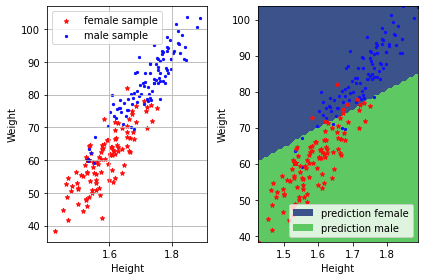

In [10]:
from helpers import de_standardize

def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    gamma = 0.01
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent", True)
    print("loss={l}".format(l=calculate_loss(y, tx, w)))

logistic_regression_gradient_descent_demo(y, x)

Calculate your Hessian below

$$\mathcal H_{\mathcal L}(\mathbf w) = H(\mathbf w) := X^\top S X$$

with $S$ a diagonal matrix such that 

$$S_{nn}:= \sigma(\mathbf x^\top_n \mathbf w) \left[ 1 - \sigma(\mathbf x_n^\top \mathbf w) \right]$$

For implementation, we have to care about efficiency of matrix multiplication. $S$ is a symmetric matrix, so we actually do *not* need to create a full $N\times N$ matrix containing mainly zeros. We can instead rely on the following property when multiplying an arbitrary matrix $A \in \mathbb R ^{N\times D}$ with a digonal matrix $D \in \mathbb R ^{D\times D}$:

$$AD = 
\begin{bmatrix}\mathbf a_1 & \cdots & \mathbf a_D \end{bmatrix}
\begin{bmatrix}
d_1 & &0 \\
& \ddots & \\
0& & d_D
\end{bmatrix} = 
\begin{bmatrix}
d_1 \mathbf a_1 & \cdots & d_D \mathbf a_D
\end{bmatrix}
$$

where $\mathbf a_j$ are the columns of $A$ and $d_j$ the elements on the diagonal of $D$.

This tells us that instead of performing a matrix multiplication with cost $O\left(ND^2\right)$, we can multiply the $D$ columns of $A$ in time $O\left(ND\right)$.

In [11]:
%%timeit
n = 1000
np.ones((12, n)).dot(np.diag(np.arange(n)))

4.12 ms ± 533 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit
n = 1000
np.multiply(np.ones((12,n)) , np.arange(n)[None, :])

16.8 µs ± 85.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
def calculate_hessian(y, tx, w):
    """return the Hessian of the loss function."""
    # S is diagonal: inefficient to allocate whole matrix when N is large
    # We perform broadcasted element-wise multiplication
    s = tx.dot(w)
    diagS = (sigmoid(s) * (1 - sigmoid(s)))[:, 0]
    tx.T * diagS[None, :]
    return (tx.T * diagS[None, :]).dot(tx)

Write a function below to return loss, gradient, and Hessian.

In [14]:
def logistic_regression(y, tx, w):
    """return the loss, gradient, and Hessian."""
    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y, tx, w)
    hess = calculate_hessian(y, tx, w)
    return loss, grad, hess

### Using Newton's method
Use Newton's method for logistic regression.

The gradient step with the Hessian is:

$$\mathbf w \leftarrow \mathbf w - \gamma \: H^{-1}(\mathbf w) \:\vec\nabla\mathcal  L(\mathbf w)$$

In [15]:
def learning_by_newton_method(y, tx, w, gamma):
    """
    Do one step on Newton's method.
    return the loss and updated w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # return loss, gradient and Hessian: TODO
    # ***************************************************
    loss, grad, hess = logistic_regression(y, tx, w)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # update w: TODO
    # ***************************************************
    w = w - np.linalg.inv(hess).dot(grad)
    
    return loss, w

demo

Current iteration=0, the loss=138.62943611198904
Current iteration=1, the loss=63.41155373909589
Current iteration=2, the loss=47.304586199350595
Current iteration=3, the loss=41.99746742248447
Current iteration=4, the loss=40.95639863723794
Current iteration=5, the loss=40.89511993648958
Current iteration=6, the loss=40.89482561762708
Current iteration=7, the loss=40.89482560989059
loss=40.89482560989058


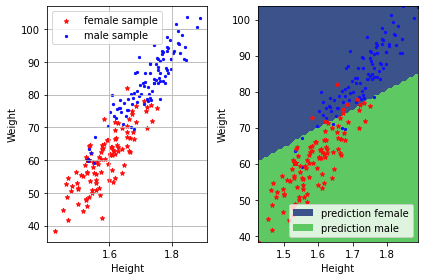

In [16]:
def logistic_regression_newton_method_demo(y, x):
    # init parameters
    max_iter = 100
    threshold = 1e-8
    lambda_ = 0.1
    gamma = 1.
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_newton_method(y, tx, w, gamma)
        # log info
        if iter % 1 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_newton_method",True)
    print("loss={l}".format(l=calculate_loss(y, tx, w)))

logistic_regression_newton_method_demo(y, x)

### Using penalized logistic regression (first-order, no Newton)
Fill in the function below.

Using the $L_2$ norm as a regularizer, we have:


$$\vec\nabla \Omega(\mathbf w) = 2\lambda \mathbf w$$

A note about the offset: we don't want to regularize it. We assume that all our algorithms receive the $\tilde X$ matrix with the first column being 1's to match the offset $w_0$. If we have $D$ features, we have a $(D+1)$-dimensional model. We assume that the weights given in arguments contains the offset, i.e. $\mathbf w = (w_0, w_1, \dots, w_D)$. 

We have to take a few modifications into account to the formulas in order **not to regularize the offset term $w_0$**. We explicit all computations to make things clear. We have two choices:

1. Compute gradient and Hessian with offset $w_0$ and put zero values where needed
1. Compute gradient and Hessian without offset $w_0$

Both implementations should adapt to the step when we combine the values of the loss function $\mathcal L$ and those of the regularizer $\Omega$. Here we choose step 1:


* $\Omega(\mathbf w) = \lambda \begin{bmatrix}w_1&\cdots&w_D\end{bmatrix} \begin{bmatrix}w_1&\cdots&w_D\end{bmatrix}^\top$

* $\vec\nabla \Omega(\mathbf w) = 2\lambda \begin{bmatrix}0 & w_1&\cdots&w_D\end{bmatrix}^\top$

* $H_\Omega(\mathbf w) = 2\lambda \tilde I$. Where $\tilde I_{ij}$ is the identity matrix but with element $(1,1)$ having a $0$ instead of $1$, i.e. $\tilde I_{ij}= 
\begin{cases}
0 & \text{ if } i=j=1\\
I_{ij} & \text{ otherwise}
\end{cases}$

We simply add of of those terms to $\mathcal L$, $\nabla \mathcal L, \mathcal H_{\mathcal L}$ by linearity of differentiation. 

In [17]:
def penalized_logistic_regression(y, tx, w, lambda_, verbose=False):
    """return the loss, gradient, and Hessian."""
    def regularizer_penalty(w, lambda_):
        """w = (w0, w1, ..., wD). doesn't regularize the offset w_0"""
        return lambda_ * w[1:].T.dot(w[1:]).ravel()
    
    def regularizer_grad(w, lambda_):
        grad = 2*lambda_ * w
        grad[0] = 0.0
        return grad
    
    def regularizer_hessian(w, lambda_):
        """w = (w0, w1, ..., wD). doesn't regularize the offset w_0"""
        I = np.eye(w.size)
        I[0, 0] = 0.0
        return 2*lambda_*I
    
    # Compute non-penalized loss, gradient, hessian
    loss, grad, hess = logistic_regression(y, tx, w)
    if verbose:
        print(f'current weight\n{w}')
        print(f'BEFORE:\nloss\n{loss}\ngrad\n{grad}\nhess\n{hess}')
    # Add penalization
    loss += regularizer_penalty(w, lambda_)
    grad += regularizer_grad(w, lambda_)
    hess += regularizer_hessian(w, lambda_)
    
    if verbose:
        print(f'loss pen\n{regularizer_penalty(w, lambda_)}\ngrad pen\n{regularizer_grad(w, lambda_)}\nhess pen\n', 
regularizer_hessian(w, lambda_))
        print(f'AFTER:\nloss\n{loss}\ngrad\n{grad}\nhess\n{hess}')
    
    return loss, grad, hess

In [18]:
def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # return loss, gradient: TODO
    # ***************************************************
    loss, grad, hess = penalized_logistic_regression(y, tx, w, lambda_)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # update w: TODO
    # ***************************************************
    w = w - gamma * np.linalg.inv(hess).dot(grad)
    return loss, w

Current iteration=0, loss=[138.62943611]
Current iteration=100, loss=[72.82564192]
Current iteration=200, loss=[52.68815887]
Current iteration=300, loss=[46.64871683]
Current iteration=400, loss=[45.28591319]
Current iteration=500, loss=[45.04881231]
Current iteration=600, loss=[45.01332933]
Current iteration=700, loss=[45.00836657]
Current iteration=800, loss=[45.00769087]
Current iteration=900, loss=[45.0075998]
Current iteration=1000, loss=[45.00758757]


(array([[ 0.17820139],
        [ 1.52743511],
        [-5.44980804]]),
 41.80423959663503)

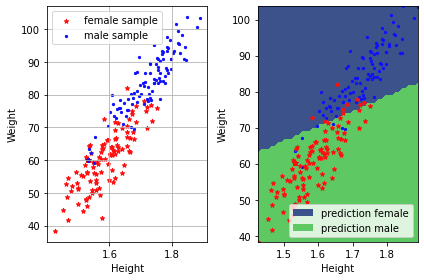

In [19]:
def logistic_regression_penalized_gradient_descent_demo(y, x, lambda_, print_penatly=False):
    # init parameters
    max_iter = 10000
    gamma = 0.01
    threshold = 1e-8
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_penalized_gradient_descent",True)
    loss = calculate_loss(y, tx, w)
    if print_penatly:
        penalized_logistic_regression(y, tx, w, lambda_, True)
    return w, loss
    
logistic_regression_penalized_gradient_descent_demo(y, x, lambda_=.1)

Current iteration=0, loss=[138.62943611]
Current iteration=100, loss=[71.918038]
Current iteration=200, loss=[50.44259271]
Current iteration=300, loss=[43.22736414]
Current iteration=400, loss=[41.33630188]
Current iteration=500, loss=[40.9643828]
Current iteration=600, loss=[40.90478512]
Current iteration=700, loss=[40.8961944]
Current iteration=800, loss=[40.89501075]
Current iteration=900, loss=[40.89485051]
Current iteration=1000, loss=[40.89482895]
current weight
[[ 0.23835736]
 [ 2.46327405]
 [-6.99410705]]
BEFORE:
loss
40.89482608530503
grad
[[-3.38158024e-05]
 [ 1.13787178e-03]
 [ 1.31803931e-03]]
hess
[[12.23794217  0.1614076   0.5888921 ]
 [ 0.1614076   5.66307628  3.19044858]
 [ 0.5888921   3.19044858  2.45780355]]
loss pen
[5.49852524e-09]
grad pen
[[ 0.00000000e+00]
 [ 4.92654809e-10]
 [-1.39882141e-09]]
hess pen
 [[0.e+00 0.e+00 0.e+00]
 [0.e+00 2.e-10 0.e+00]
 [0.e+00 0.e+00 2.e-10]]
AFTER:
loss
[40.89482609]
grad
[[-3.38158024e-05]
 [ 1.13787227e-03]
 [ 1.31803791e-03]]

(array([[ 0.23835736],
        [ 2.46327405],
        [-6.99410705]]),
 40.89482608530503)

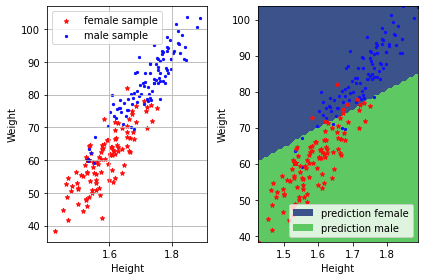

In [20]:
logistic_regression_penalized_gradient_descent_demo(y, x, lambda_=1e-10, print_penatly=True)

Current iteration=0, loss=[138.62943611]
Current iteration=100, loss=[122.30609995]
Current iteration=200, loss=[120.0806403]
Current iteration=300, loss=[119.77933004]
Current iteration=400, loss=[119.73878603]
Current iteration=500, loss=[119.73334505]
Current iteration=600, loss=[119.73261563]
Current iteration=700, loss=[119.73251788]
Current iteration=800, loss=[119.73250478]
current weight
[[ 0.04204717]
 [-0.22722665]
 [-0.28049769]]
BEFORE:
loss
106.70141296703261
grad
[[-3.12783784e-04]
 [ 4.54560749e+01]
 [ 5.61119816e+01]]
hess
[[47.12813603  0.3158677   0.35688967]
 [ 0.3158677  44.28263716 40.58304195]
 [ 0.35688967 40.58304195 44.34576319]]
loss pen
[13.03109026]
grad pen
[[  0.        ]
 [-45.44532939]
 [-56.0995378 ]]
hess pen
 [[  0.   0.   0.]
 [  0. 200.   0.]
 [  0.   0. 200.]]
AFTER:
loss
[119.73250323]
grad
[[-0.00031278]
 [ 0.01074555]
 [ 0.01244379]]
hess
[[ 47.12813603   0.3158677    0.35688967]
 [  0.3158677  244.28263716  40.58304195]
 [  0.35688967  40.58304

(array([[ 0.04204717],
        [-0.22722665],
        [-0.28049769]]),
 106.70141296703261)

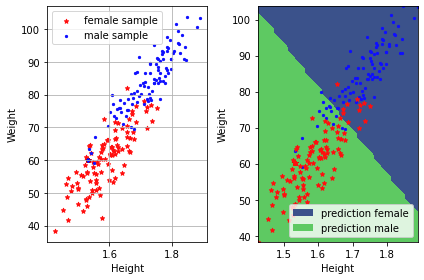

In [21]:
logistic_regression_penalized_gradient_descent_demo(y, x, lambda_=100, print_penatly=True)

In [22]:
tx = np.c_[np.ones((y.shape[0], 1)), x]
w = np.zeros((tx.shape[1], 1))
penalized_logistic_regression(y, tx, w, 1e10, True)
loss, w = learning_by_gradient_descent(y, tx, w, .7)
print('-'*30)
penalized_logistic_regression(y, tx, w, 1e10, True)

current weight
[[0.]
 [0.]
 [0.]]
BEFORE:
loss
138.62943611198904
grad
[[-2.        ]
 [68.74603697]
 [79.61302092]]
hess
[[ 5.00000000e+01 -7.90478794e-14  7.83817455e-14]
 [-7.90478794e-14  5.00000000e+01  4.60676209e+01]
 [ 7.83817455e-14  4.60676209e+01  5.00000000e+01]]
loss pen
[0.]
grad pen
[[0.]
 [0.]
 [0.]]
hess pen
 [[0.e+00 0.e+00 0.e+00]
 [0.e+00 2.e+10 0.e+00]
 [0.e+00 0.e+00 2.e+10]]
AFTER:
loss
[138.62943611]
grad
[[-2.        ]
 [68.74603697]
 [79.61302092]]
hess
[[ 5.00000000e+01 -7.90478794e-14  7.83817455e-14]
 [-7.90478794e-14  2.00000000e+10  4.60676209e+01]
 [ 7.83817455e-14  4.60676209e+01  2.00000000e+10]]
------------------------------
current weight
[[  1.4       ]
 [-48.12222588]
 [-55.72911464]]
BEFORE:
loss
873.682047523039
grad
[[  0.86848863]
 [-13.03943483]
 [ -4.33312509]]
hess
[[ 1.10560744 -0.08230917  0.10236369]
 [-0.08230917  0.04803978 -0.04463261]
 [ 0.10236369 -0.04463261  0.04300274]]
loss pen
[5.42148284e+13]
grad pen
[[ 0.00000000e+00]
 [-9.6

(array([5.42148284e+13]),
 array([[ 8.68488633e-01],
        [-9.62444518e+11],
        [-1.11458229e+12]]),
 array([[ 1.10560744e+00, -8.23091707e-02,  1.02363691e-01],
        [-8.23091707e-02,  2.00000000e+10, -4.46326068e-02],
        [ 1.02363691e-01, -4.46326068e-02,  2.00000000e+10]]))